In [14]:
import pickle
import os
import sys
from typing import Any, Dict, Hashable
from kafka import KafkaConsumer
import json
import pandas as pd
import numpy as np
import datetime as dt
from river import (
    base,
    compose, 
    metrics, 
    drift,
    forest,
    cluster,
    preprocessing,
    time_series,
    linear_model,
    optim,
    bandit,
    model_selection
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)
from xgboost import XGBClassifier
from yellowbrick import (
    classifier,
    features,
    target,
    model_selection
)
import matplotlib.pyplot as plt
from functions import (
    create_consumer,
    load_or_create_data,
    process_batch_data,
    create_batch_model
)

In [15]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [16]:
DATA_PATH = "data/transaction_fraud_detection.parquet"
MODEL_FOLDER = "models/transaction_fraud_detection"
ENCODERS_PATH = "encoders/sklearn/transaction_fraud_detection.pkl"
YELLOWBRICK_PATH = f"{MODEL_FOLDER}/yellowbrick"
PROJECT_NAME = "Transaction Fraud Detection"

In [17]:
os.makedirs(MODEL_FOLDER, exist_ok = True)
os.makedirs("encoders/sklearn", exist_ok = True)
os.makedirs("data", exist_ok = True)
for x in [
    "classification",
    "feature_analysis",
    "target",
    "model_selection"
]:
    os.makedirs(f"{YELLOWBRICK_PATH}/{x}", exist_ok = True)

In [18]:
data_df = load_or_create_data(
    ...,
    PROJECT_NAME) #REPLACE FOR DELTA LAKE AND PYSPARK LATER
X_train, X_test, y_train, y_test = process_batch_data(
    data_df, 
    PROJECT_NAME)
#X_train, X_test, y_train, y_test = X_train.head(10000), X_test.head(10000), y_train.head(10000), y_test.head(10000)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
#X = X.head(10000)
#y = y.head(10000)

Data loaded from disk.


In [19]:
binary_classes = list(set(y_train.unique().tolist() + y_test.unique().tolist()))
binary_classes.sort()

In [20]:
def yellowbrick_classification_kwargs(
    PROJECT_NAME,
    y_train,
    binary_classes
):
    return {
        "ClassificationReport": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
            "classes": binary_classes,
            "support": True,
        },
        "ConfusionMatrix": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
            "classes": binary_classes,
        },
        "ROCAUC": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
            "classes": binary_classes,
        },
        "PrecisionRecallCurve": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
        },
        "ClassPredictionError": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
            "classes": binary_classes,
        },
        #"DiscriminationThreshold": {
        #    "estimator": create_batch_model(
        #        PROJECT_NAME,
        #        y_train = y_train),
        #}
    }


def yellowbrick_classification_visualizers(
    yb_classification_kwargs,
    X_train,
    X_test,
    y_train,
    y_test,
    YELLOWBRICK_PATH
):
    for visualizer_name in yb_classification_kwargs.keys():
        print(visualizer_name)
        visualizer = getattr(classifier, visualizer_name)(**yb_classification_kwargs[visualizer_name])
        if visualizer_name in ["DiscriminationThreshold"]:
            X = pd.concat([X_train, X_test])
            y = pd.concat([y_train, y_test])
            visualizer.fit(X, y)
        else:
            visualizer.fit(X_train, y_train)
            visualizer.score(X_test, y_test)
        visualizer.show();
        visualizer.fig.savefig(f"{YELLOWBRICK_PATH}/classification/{visualizer.__class__.__name__}.png")
        plt.clf()

In [21]:
#>>>--- Classification Visualizers ---<<<#
#yb_classification_kwargs = yellowbrick_classification_kwargs(
#    PROJECT_NAME,
#    y_train,
#    binary_classes
#)
#yellowbrick_classification_visualizers(
#    yb_classification_kwargs,
#    X_train,
#    X_test,
#    y_train,
#    y_test,
#    YELLOWBRICK_PATH
#)

In [22]:
def yellowbrick_feature_analysis_kwargs(
    classes,
    features = None
):
    return {
        #"RadViz": {
        #    "classes": classes,
        #},
        #"Rank1D": {
        #    "algorithm": "shapiro",
        #},
        #"Rank2D": {
        #    "algorithm": "pearson",
        #},
        "ParallelCoordinates": {
            "classes": classes,
            "features": features,
            "sample": 0.05,
            "shuffle": True,
            #"fast": True,
        },
        "PCA": {
            "classes": classes,
            "scale": True,
            #"projection": 3,
            #"proj_features": True,
        },
        #"Manifold": {
        #    "classes": classes,
        #    "manifold": "tsne",
        #},
        #JointPlotVisualizer
    }


def yellowbrick_feature_analysis_visualizers(
    yb_feature_analysis_kwargs,
    X,
    y,
    YELLOWBRICK_PATH
):
    for visualizer_name in yb_feature_analysis_kwargs.keys():
        print(visualizer_name)
        visualizer = getattr(features, visualizer_name)(**yb_feature_analysis_kwargs[visualizer_name])
        if visualizer_name in [
            "ParallelCoordinates",
            "PCA",
            "Manifold"]:
            visualizer.fit_transform(X, y)
        else:
            visualizer.fit(X, y)
            visualizer.transform(X)
        visualizer.show();
        visualizer.fig.savefig(f"{YELLOWBRICK_PATH}/feature_analysis/{visualizer.__class__.__name__}.png")
        plt.clf()

In [23]:
##>>>--- Feature Analysis ---<<<#
#yb_feature_analysis_kwargs = yellowbrick_feature_analysis_kwargs(
#    binary_classes
#)
#yellowbrick_feature_analysis_visualizers(
#    yb_feature_analysis_kwargs,
#    X,
#    y,
#    YELLOWBRICK_PATH
#)

In [24]:
def yellowbrick_target_kwargs(
    labels = None,
    features = None
):
    return {
        "BalancedBinningReference": {
        },
        "ClassBalance": {
            "labels": labels,
        },
        #"FeatureCorrelation": {
        #    "labels": features,
        #}
    }


def yellowbrick_target_visualizers(
    yb_target_kwargs,
    X,
    y,
    YELLOWBRICK_PATH
):
    for visualizer_name in yb_target_kwargs.keys():
        print(visualizer_name)
        visualizer = getattr(target, visualizer_name)(**yb_target_kwargs[visualizer_name])
        if visualizer_name in [
            "BalancedBinningReference",
            "ClassBalance"
            ]:
            visualizer.fit(y)
        else:
            visualizer.fit(X, y)
        visualizer.show();
        visualizer.fig.savefig(f"{YELLOWBRICK_PATH}/target/{visualizer.__class__.__name__}.png")
        plt.clf()

In [25]:
##>>>--- Target ---<<<#
#labels = list(set(y_train.unique().tolist() + y_test.unique().tolist()))
#features = X_train.columns.tolist()
#yb_target_kwargs = yellowbrick_target_kwargs(
#    labels,
#    features
#)
#yellowbrick_target_visualizers(
#    yb_target_kwargs,
#    X,
#    y,
#    YELLOWBRICK_PATH
#)

In [ ]:
def yellowbrick_model_selection_kwargs(
    PROJECT_NAME,
    y_train
    ):
    return {
        "ValidationCurve": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
            "param_name": "gamma",
            "param_range": np.logspace(-6, -1, 10),
            "logx": True,
            "cv": StratifiedKFold(
                n_splits = 5,
                shuffle = True, 
                random_state = 42
            ),
            "scoring": "average_precision",
        },
        "LearningCurve": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
            "cv": StratifiedKFold(
                n_splits = 5,
                shuffle = True, 
                random_state = 42
            ),
            "scoring": "average_precision",
            "train_sizes": np.linspace(0.3, 1.0, 8),
        },
        "CVScores": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
            "cv": StratifiedKFold(
                n_splits = 5,
                shuffle = True, 
                random_state = 42
            ),
            "scoring": "average_precision",
        },
        "FeatureImportances": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
        },
        #"RFECV": {
        #    "estimator": create_batch_model(
        #        PROJECT_NAME,
        #        y_train = y_train),
        #    "cv": StratifiedKFold(
        #        n_splits = 5,
        #        shuffle = True, 
        #        random_state = 42
        #    ),
        #    "scoring": "average_precision",
        #}, #Take too long to process, don't use
        "DroppingCurve": {
            "estimator": create_batch_model(
                PROJECT_NAME,
                y_train = y_train),
        }
    }


def yellowbrick_model_selection_visualizers(
    yb_model_selection_kwargs,
    X,
    y,
    YELLOWBRICK_PATH
):
    for visualizer_name in yb_model_selection_kwargs.keys():
        print(visualizer_name)
        visualizer = getattr(model_selection, visualizer_name)(**yb_model_selection_kwargs[visualizer_name])
        if visualizer_name in ["ValidationCurve", "RFECV"]:
            X_stratified, _, y_stratified, _ = train_test_split(
                X, y,
                train_size = 50000,
                shuffle = True,
                stratify = y,
                random_state = 42
            )
            visualizer.fit(X_stratified, y_stratified)
        else:
            visualizer.fit(X, y)
        visualizer.show();
        visualizer.fig.savefig(f"{YELLOWBRICK_PATH}/model_selection/{visualizer.__class__.__name__}.png")
        plt.clf()

DroppingCurve


/home/rafaelcoelho/Workbench/COELHORealTime/tests/.venv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/rafaelcoelho/Workbench/COELHORealTime/tests/.venv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
No

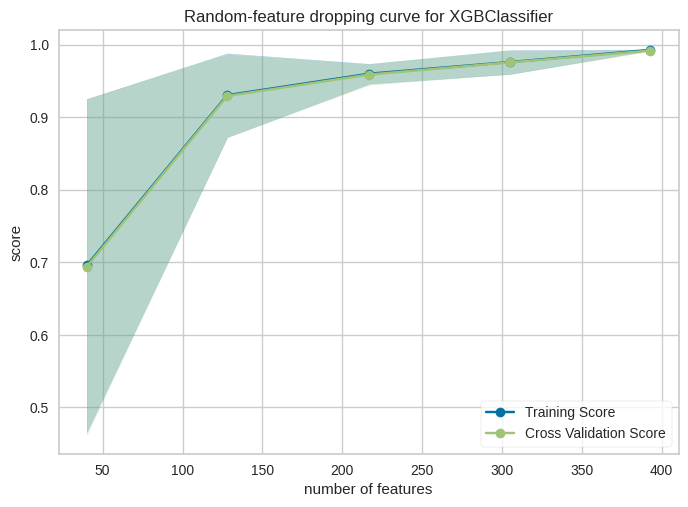

<Figure size 800x550 with 0 Axes>

In [45]:
#>>>--- Model Selection ---<<<#
yb_model_selection_kwargs = yellowbrick_model_selection_kwargs(
    PROJECT_NAME,
    y_train
)
yellowbrick_model_selection_visualizers(
    yb_model_selection_kwargs,
    X,
    y,
    YELLOWBRICK_PATH
)